In [76]:
import numpy as np
import pandas as pd
pd.set_option('max_columns', 105)
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
%matplotlib inline
sns.set()

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore")

In [102]:
df=pd.read_csv('sl.csv')
print(df.shape)
df.head()

(306197, 4)


,title,show,click,ctr
0,《香蜜》幕后照：邓伦杨紫深情对视，润玉片场耍帅！,2251,501,22.256775
1,他演两次“傻子”摘得视帝，如今娶西游记中红孩儿，儿女双全,5559,1324,23.817233
2,修路挖出2.4米长冬眠缅甸蟒 胆大村民将蟒蛇抱回村,1471,251,17.063222
3,妈妈曾撮合她和邓超处对象，她却执意嫁煤老板，结婚1年就离婚,1544,344,22.279793
4,新年新气象！陈坤唐嫣周冬雨热巴等群星花式拜年,1151,111,9.643788


In [103]:
df.sort_values(by=['show'],ascending=False,inplace=True)
df2= df[df.ctr<20]
df2.sort_values(by=['ctr'],ascending=False,inplace=True)
print(df2.shape)
df2.head(100)

(245158, 4)


,title,show,click,ctr
252098,世界上最难暗杀的三个人，一中国人上榜，其中一人经历638次暗,11206,2241,19.998215
76061,外国游客疑惑：三峡大坝落差113米，船是怎么通过的？,10286,2057,19.998056
108987,真是谈癌色变，又一位明星得了癌症晚期，希望能够开心快乐每一天,9586,1917,19.997914
169457,杨紫给林志玲擦嘴，却忍不住偷亲，林志玲的举动瞬间暴露人品,8201,1640,19.997561
239295,41岁李玉刚全家照，生活中是纯爷们，帅气像父亲，女儿很惊艳,6766,1353,19.997044
226397,这个淘气的小女孩，原来就是她的女儿，圈外老公足足追了她10年,20048,4009,19.997007
52158,幽默笑话:一富婆被绑架，5绑匪打电话给她老公，要3000万赎,6231,1246,19.996790
30859,23岁单身男子，查出肝癌离世，医生叹气：这种“筷子”，最好别用,22369,4473,19.996424
182357,男人若是长期不排精，身体会有哪些改变？看完或许会害羞！,11127,2225,19.996405
225142,王俊凯客串《都挺好》，虽然镜头只有1秒，但看见他粉丝就很高兴,5541,1108,19.996391


In [104]:
df = df[df.title.apply(lambda x: len(str(x))>5)]
df.sort_values(by=['ctr'],ascending=False,inplace=True)
df.query('show > 1000').head(20)

,title,show,click,ctr
77782,林黛玉不过是替身，这个人才是宝玉真爱，曹雪芹早就言明二人有染,1153,656,56.895056
144254,当前值得入手的四款旗舰手机，无刘海无水滴，价格厚道,1136,638,56.161972
223491,它是国产手机拍摄水准的标杆，优秀的性能让人爱不释手,1144,641,56.031469
281307,雷军继续放狠招，红米新旗舰命名X20pro，参数基本被确定,1153,633,54.900260
132285,搞笑段子：每次和老婆顶嘴，最后都要被罚跪！,1124,611,54.359431
74901,买手机别盲目跟风，三款高性价比的实用型手机，你看上了谁？,1190,646,54.285714
31697,中国科技芯片出现黑马，这个让华为都有点害怕的存在，你知道吗？,1072,576,53.731343
90059,每日一笑：开什么远光灯，没看我们正撒尿吗？,1063,571,53.715898
96241,每日一笑：谢谢你一踹之恩啊，估计把当年生我的劲都用上了吧？,1092,585,53.571429
98941,《红楼梦》中的潇湘妃子林黛玉最终结局一直成谜，真相原来是这样,1489,796,53.458697


In [9]:
df[df.title=='秘制卤肉配方来袭，鲜香入味还不腻，越吃越香，超级解馋']

,title,show,click,ctr
133537,秘制卤肉配方来袭，鲜香入味还不腻，越吃越香，超级解馋,1107,289,26.106594


In [105]:
df.describe()

,show,click,ctr
count,3.059620e+05,305962.000000,305962.000000
mean,7.009093e+03,878.349681,14.849834
std,2.880266e+04,2559.632234,6.682692
min,1.001000e+03,1.000000,0.014364
25%,1.426000e+03,194.000000,10.954004
50%,2.339000e+03,347.000000,15.024410
75%,5.216000e+03,778.000000,18.966974
max,2.083102e+06,114778.000000,56.895056


In [110]:
neg= df[df.ctr < 12]
neg.shape

(92325, 4)

In [109]:
pos= df[df.ctr > 20]
pos.shape

(60930, 4)

In [260]:
mid =  df.query('ctr>16 and ctr<30')
mid.shape       

(189548, 4)

In [74]:
pos.head(20)

NameError: name 'pos' is not defined

In [24]:
pos.sort_values(by=['show'],ascending=False,inplace=True)
pos.head(20)

,title,show,click,ctr
277760,女子在身上画了一件旗袍，“公然”考验路人的眼力，却无人能辩！,264017,64545,24.447289
56906,冰冻500年的少女，仍身体丰满宛如睡着，专家从她头发揭秘死因,249815,53605,21.457879
223866,张柏芝哭着说出儿子亲生父亲，总算还张柏芝清白了,233933,47762,20.416957
37075,71岁侯耀华陪女徒弟共度四天四夜，儿子发文怒骂垃圾，望洁身自好,213204,43673,20.484137
105968,刘德华病情已经确诊，比预料还要严重，剩下7场演唱会全部取消！,202921,43127,21.253098
265691,她11岁被导演看中，和著名导演同居多年，如今复出却没人关注,200381,46455,23.183336
302471,她与丈夫差23岁，丈夫临终前用一部戏将其捧红，今已守寡5年,196790,40068,20.360791
49715,“老公”称呼已经过时，听听关晓彤怎么叫鹿晗的，网友：太甜了！,184642,37125,20.106476
115262,继李咏和姚贝娜后，又一位明星也抗癌失败，最后愿望是想活到7月,182874,40330,22.053436
224600,李连杰4个女儿私照曝光，差距不是一般的大，黄秋燕女儿完胜利智,177424,37751,21.277279


In [111]:
neg['label'] = 0
pos['label'] = 1

In [112]:
n= neg[['title','label']]
p= pos[['title','label']]
res= pd.concat([n,p]).reset_index(drop=True)
print(res.shape)
res.head()


(153255, 2)


,title,label
0,凉山一男子怀疑妻子与他人有不正当男女关系，然后……,0
1,8月之后小人霉运无法靠近，事事顺心如意，前途不可限量的3生肖,0
2,史上仅此一人有如此离奇经历：先当皇后再当太后，最后当公主,0
3,浙江“补胎枪”一出，没人再花钱叫拖车！女司机也能补，车车适用,0
4,杨超越首部电视剧作品演技让人惊喜 其实她演戏方面还是有天然优势的,0


In [113]:
# save to CSV
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

res = shuffle(res)

tr,te= train_test_split(res, test_size=0.1)
print(tr.shape)
print(te.shape)
tr.reset_index(drop=True,inplace=True)
te.reset_index(drop=True,inplace=True)
tr.to_csv('train2.csv',header=False)
te.to_csv('eval2.csv',header=False)
# df[['title','label']].to_csv('bert_shuffle.csv')

(137929, 2)
(15326, 2)


# Load bert result
---

In [180]:
df_raw=pd.read_csv('predict_raw.csv',header=None)
df_raw.columns = ['title','label']
print(df_raw.shape)

(14945, 2)


In [181]:
df_res=pd.read_csv('./output_lr/test_results.csv',header=None)
df_res.columns = ['prob1','prob2']
t=df_res.values.tolist()

df_raw['prob']=t

df_raw['pre_label']= np.argmax(t, axis=1)
df_raw['confident']= [x[1] for x in t]
# df_raw['pre_label']= 0
# df_raw['pre_label'][df_raw.confident>0.5]=1

# for eval
df_tp= df_raw[(df_raw.label==1) & (df_raw.pre_label==1)]
df_tn= df_raw[(df_raw.label==0) & (df_raw.pre_label==0)]
df_fp= df_raw[(df_raw.label==0) & (df_raw.pre_label==1)]
df_fn= df_raw[(df_raw.label==1) & (df_raw.pre_label==0)]
tp = df_tp.shape[0]
tn = df_tn.shape[0]
fp = df_fp.shape[0]
fn = df_fn.shape[0]
n =df_raw.shape[0]
df_raw.head(10)

,title,label,prob,pre_label,confident
0,搞笑笑话：爱慕一个女生好久了，一直不知道她是哪个班哪个系的,1,"[0.029306857000000002, 0.9706931999999999]",1,0.970693
1,快来围观！博白疑似发现珍稀物种“蛇中熊猫”,0,"[0.9942561, 0.005743921999999999]",0,0.005744
2,深圳暴雨死亡人数增至6人 仍在全力搜救,0,"[0.9930899999999999, 0.0069100326]",0,0.006910
3,一个快被遗忘的女明星，因《金婚》而走红，今49岁优雅而干练,1,"[0.12603909, 0.8739609]",1,0.873961
4,曾经的通讯巨头，在4G时代被中国移动抛弃，现已连续亏损15年,1,"[0.45585415, 0.5441459]",1,0.544146
5,难怪孙悟空翻不出如来手掌心，你看佛祖头上的“葡萄”是啥来头,1,"[0.055705055999999996, 0.9442949]",1,0.944295
6,林心如卸妆后，她是真的很漂亮，图3发现真面目,1,"[0.096069045, 0.9039309999999999]",1,0.903931
7,德云社十天聚了两次，岳云鹏的表现亮了，简直是拿生命在捧场！,1,"[0.105430655, 0.8945693000000001]",1,0.894569
8,西藏“老政法”履新！28个省区市公安一把手同时任省府副手,0,"[0.9766306999999999, 0.02336935]",0,0.023369
9,西葫芦新吃法，不蒸不烙，做一次能吃一周，外酥里鲜，比吃肉还香,1,"[0.20187281, 0.7981272]",1,0.798127


tp= 5239
tn= 7334
fp= 1424
fn= 948
n= 14945
accuracy = 0.8412847106055537
precision = 0.7862824553504427
recall = 0.8467754970098594
F1 score = 0.8154085603112841
tpr = 0.8467754970098594
fpr = 0.16259419958894725
auc= 0.9198679021600994


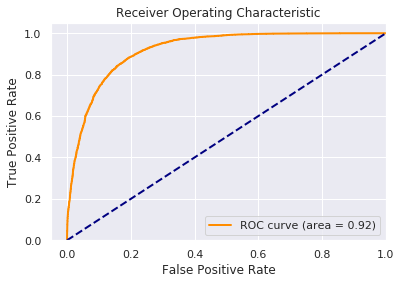

In [182]:
print('tp=',tp)
print('tn=',tn)
print('fp=',fp)
print('fn=',fn)
print('n=',n)
accuracy = (tp+tn)/n
precision = tp / (tp+fp)
recall = tp / (tp+fn)
F1 = (2*precision*recall) / (precision+recall)
tpr = tp / (tp+fn)
fpr = fp / (fp+tn)

print('accuracy =',accuracy)
print('precision =',precision)
print('recall =',recall)
print('F1 score =',F1)
print('tpr =',tpr)
print('fpr =',fpr)
from sklearn import metrics
y=df_raw.label.values
pred= df_raw.confident.values
fpr, tpr, thresholds = metrics.roc_curve(y_true=y, y_score=pred, pos_label=1)
roc_auc = metrics.auc(fpr, tpr)
print('auc=', roc_auc)

plt.figure()
linewidth = 2
plt.plot(fpr, tpr, color='darkorange',lw=linewidth, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=linewidth, linestyle='--')
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

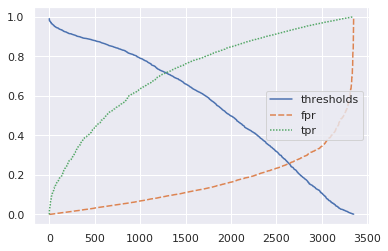

In [183]:
# red dashes, blue squares and green triangles
thresholds= np.array(thresholds.tolist()[1:])
fpr= np.array(fpr.tolist()[1:])
tpr =np.array(tpr.tolist()[1:])

d = {'thresholds': thresholds,'fpr':fpr,'tpr':tpr}
df_roc = pd.DataFrame(data=d)
fig, ax = plt.subplots()
sns.lineplot(data=df_roc)

# idx= range(len(thresholds))
# plt.plot(idx, thresholds, 'g--',idx, tpr, 'r--', idx, fpr, 'b--')
# plt.show()
# sns.lineplot(x="idx", y="fpr",ax= ax,data=df_roc,label='fpr')
# sns.lineplot(x="idx", y="tpr",ax= ax,data=df_roc,label='tpr')
# sns.lineplot(x="idx", y="thresholds",ax= ax,data=df_roc,label='thresholds')

In [173]:
df_raw.query('confident>0.6').head(20)

,title,label,prob,pre_label,confident
0,搞笑笑话：爱慕一个女生好久了，一直不知道她是哪个班哪个系的,1,"[0.103898525, 0.89610153]",1,0.896102
3,一个快被遗忘的女明星，因《金婚》而走红，今49岁优雅而干练,1,"[0.17005856, 0.8299414]",1,0.829941
5,难怪孙悟空翻不出如来手掌心，你看佛祖头上的“葡萄”是啥来头,1,"[0.178365, 0.82163495]",1,0.821635
6,林心如卸妆后，她是真的很漂亮，图3发现真面目,1,"[0.16007492, 0.83992505]",1,0.839925
7,德云社十天聚了两次，岳云鹏的表现亮了，简直是拿生命在捧场！,1,"[0.17658484, 0.82341516]",1,0.823415
9,西葫芦新吃法，不蒸不烙，做一次能吃一周，外酥里鲜，比吃肉还香,1,"[0.34047112, 0.65952885]",1,0.659529
10,荣耀性价比神机曝光：麒麟970＋屏下指纹＋5G，仅售1500！,1,"[0.18795474, 0.8120453000000001]",1,0.812045
11,春晚彩排现场曝光，迪丽热巴热情出镜，刘涛的服装太美了！,1,"[0.14380786, 0.8561921999999998]",1,0.856192
12,教育新视觉，北大学子弑母案尚未定论，有一个真相令人深思,1,"[0.105823286, 0.8941766999999999]",1,0.894177
13,中国混得最差的沿海开放城市，2016年才破千亿大关，现在又有传销,1,"[0.23174807, 0.7682519]",1,0.768252


In [184]:
df_te=pd.read_csv('test.csv')
df_te.columns = ['idx','title','label']
df_te.head(10000)

,idx,title,label
0,1,曾主持春晚多次，挤走原配甘愿做小三，今50岁幸福成这般模样,1
1,2,功夫明星硬核卖萌，甄子丹为爱扮小黄人，李连杰打拳逗乐外国人,1
2,3,年龄加起来超200岁的三位戏骨，聚在一起不拍戏拍广告，太可惜了,1
3,4,46岁董卿含泪宣布被“解雇”，新央视一姐将上任，长相甜美性感,1
4,5,洪金宝年轻时饭量有多大？最多吃过9碗米饭，盒饭老板都不想见他,1
5,6,许凯白鹿不再合作？新剧《灵剑山》备受期待，女主颜值更惊艳,1
6,7,女星在没有ps的年代有多美：袁咏仪纯净乖巧，林青霞美的真实。,1
7,8,梁宏达犀利点评并揭露范冰冰和冯小刚真实关系，网友：真敢说啊,1
8,9,“我给你带孩子，你却躺床上玩手机”，老人的话，揭中国家庭通病,1
9,10,香港娱乐圈，有大哥成龙，还有三哥、四哥，为何一直没有二哥呢？,1


In [125]:
df_te.label.unique()
# H 0.46~0.29 1121
# M 0.27~0.21 1714
# L 0.19~~~   1233
df_te['y']= 0
df_te['y'][(df_te.label=="H")]=1

df_te.head()
df_te[['title','y']].to_csv('test_bert.csv',header=False)